# Carbon Credit Price Forecasting (Alberta TIER)

## Objective
This notebook focuses on forecasting Alberta TIER carbon credit prices using
historical market price data. The goal is to evaluate whether a simple,
interpretable time-series model can capture price dynamics and produce
reasonable short-term forecasts.

Registry-level variables are explored separately and are not directly merged
into the price series to avoid granularity mismatch and data leakage.


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
import itertools
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")

from pathlib import Path

pd.set_option("display.max_columns", 100)

DATA_DIR = Path("data")
REGISTRY_PATH = r"C:\Users\shoaib\combined_data.csv"
PRICE_PATH = r"C:\Users\shoaib\Desktop\strom futures\carbon_prices.xlsx"


In [56]:
df = pd.read_csv(REGISTRY_PATH)
carbon_data = pd.read_excel(PRICE_PATH)

print("Registry shape:", df.shape)
print("Price shape:", carbon_data.shape)

df.head()

Registry shape: (1048575, 21)
Price shape: (1800, 2)


,Registry,Project_Identifier,Project_Title,Emission_Offset_Project_Developer,Quantification_Protocol,Vintage,Serial_Start,Serial_End,Type,Quantity,Current_Owner,Facility,Emission_Offset_Status,Transaction_Id,Activity_Start,Offset_Start_Date,Offset_End_Date,Expiry_Date,Verifier_Company,Compliance_Year,Effective_Date
0,AEOR,8626-3432,2007 Tillage Auction Project,Emission Credits Corporation (ECC),Tillage System Management,2007.0,8626-3432-000-000-070-058,8626-3432-000-000-107-037,NaN,36980,Heartland Generation Ltd.,NaN,Revoked,NaN,NaN,1/1/2002,12/31/2007,7/5/2021,NaN,NaN,1/1/2024
1,AEOR,8626-3432,2007 Tillage Auction Project,Emission Credits Corporation (ECC),Tillage System Management,2006.0,8626-3432-000-000-055-706,8626-3432-000-000-070-057,NaN,14352,Heartland Generation Ltd.,NaN,Revoked,NaN,NaN,1/1/2002,12/31/2007,7/5/2021,NaN,NaN,1/1/2024
2,AEOR,8626-3432,2007 Tillage Auction Project,Emission Credits Corporation (ECC),Tillage System Management,2005.0,8626-3432-000-000-041-500,8626-3432-000-000-055-705,NaN,14206,Heartland Generation Ltd.,NaN,Revoked,NaN,NaN,1/1/2002,12/31/2007,7/5/2021,NaN,NaN,1/1/2024
3,AEOR,8626-3432,2007 Tillage Auction Project,Emission Credits Corporation (ECC),Tillage System Management,2004.0,8626-3432-000-000-013-653,8626-3432-000-000-027-541,NaN,13889,Heartland Generation Ltd.,NaN,Revoked,NaN,NaN,1/1/2002,12/31/2007,7/5/2021,NaN,NaN,1/1/2024
4,AEOR,8626-3432,2007 Tillage Auction Project,Emission Credits Corporation (ECC),Tillage System Management,2003.0,8626-3432-000-000-027-542,8626-3432-000-000-041-499,NaN,13958,Heartland Generation Ltd.,NaN,Revoked,NaN,NaN,1/1/2002,12/31/2007,7/5/2021,NaN,NaN,1/1/2024


In [41]:
demand_statuses = ['Pending Retirement']
supply_statuses = ['Active']

df['Demand'] = df['Quantity'].where(df['Emission_Offset_Status'].isin(demand_statuses), 0)
df['Supply'] = df['Quantity'].where(df['Emission_Offset_Status'].isin(supply_statuses), 0)
df['Supply_Demand_Ratio'] = df['Supply'] / (df['Demand'] + 1)

df['Offset_End_Date'] = pd.to_datetime(df['Offset_End_Date'], errors='coerce')

monthly_quantity = df.set_index('Offset_End_Date')['Quantity'].resample('M').sum()

monthly_supply_demand_ratio = df.set_index('Offset_End_Date')['Supply_Demand_Ratio'].resample('M').mean()

carbon_data['DateTime'] = pd.to_datetime(carbon_data['DateTime'])
carbon_data.set_index('DateTime', inplace=True)

monthly_price = carbon_data['TIER Carbon Credit (CAD)'].resample('M').mean()

combined_data = pd.concat([monthly_price, monthly_quantity, monthly_supply_demand_ratio], axis=1).dropna()
combined_data.columns = ['TIER Carbon Credit (CAD)', 'Quantity', 'Supply_Demand_Ratio']

print(combined_data.head(20))

            TIER Carbon Credit (CAD)    Quantity  Supply_Demand_Ratio
2019-01-31                 24.790000    32653725          1873.802051
2019-08-31                 24.890000   334557405           767.279717
2019-10-31                 25.000000    97332032          4125.575255
2019-12-31                 25.000000   439705870          1654.057104
2020-03-31                 27.458636   235903005             0.000000
2020-04-30                 27.293333   149847555           775.050694
2020-12-31                 34.000000   377801571          3111.138009
2021-05-31                 38.000000   714158835             0.943820
2021-12-31                 45.000000  1116280925          5147.680432
2022-02-28                 47.000000    35875125           467.714286
2022-04-30                 45.375000     1183065            78.861538
2022-05-31                 45.000000     7116546           219.957738
2022-07-31                 45.000000    14349160          3162.330968
2022-09-30          

In [43]:
# Defining the Grid Search Function for SARIMAX
def sarimax_grid_search(target, exog, p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    results = []
    for p, d, q in itertools.product(p_values, d_values, q_values):
        for P, D, Q, s in itertools.product(P_values, D_values, Q_values, s_values):
            try:
                # Define the SARIMAX model
                model = SARIMAX(target, exog=exog, order=(p, d, q), seasonal_order=(P, D, Q, s))
                model_fit = model.fit(disp=False)
                aic = model_fit.aic
                results.append(((p, d, q, P, D, Q, s), aic))
                print(f'Tried SARIMAX{(p, d, q)} x {(P, D, Q, s)}, AIC={aic:.4f}')
            except Exception as e:
                print(f'Error: {e} for SARIMAX{(p, d, q)} x {(P, D, Q, s)}')
                continue

    # Finding the best model with the lowest AIC
    best_params, best_aic = min(results, key=lambda x: x[1])
    print(f'\nBest SARIMAX Model: SARIMAX{best_params}, AIC={best_aic:.4f}')
    return best_params

# Defining the parameter ranges to try
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
s_values = [12] 

# Runing the Grid Search to Find Optimal Parameters
target = combined_data['TIER Carbon Credit (CAD)']
exog = combined_data[['Quantity', 'Supply_Demand_Ratio']]

best_params = sarimax_grid_search(target, exog, p_values, d_values, q_values, P_values, D_values, Q_values, s_values)

# Extracting the optimized parameters
p, d, q, P, D, Q, s = best_params

# Fitting the optimized SARIMAX model
optimized_model = SARIMAX(target, exog=exog, order=(p, d, q), seasonal_order=(P, D, Q, s))
optimized_results = optimized_model.fit(disp=False)

# Printing the summary of the optimized model
print(optimized_results.summary())


Tried SARIMAX(0, 0, 0) x (0, 0, 0, 12), AIC=276.1368
Tried SARIMAX(0, 0, 0) x (0, 0, 1, 12), AIC=232.2714
Tried SARIMAX(0, 0, 0) x (0, 1, 0, 12), AIC=114.2996
Tried SARIMAX(0, 0, 0) x (0, 1, 1, 12), AIC=100.7711
Tried SARIMAX(0, 0, 0) x (1, 0, 0, 12), AIC=227.6621
Tried SARIMAX(0, 0, 0) x (1, 0, 1, 12), AIC=234.2714
Tried SARIMAX(0, 0, 0) x (1, 1, 0, 12), AIC=100.4029
Tried SARIMAX(0, 0, 0) x (1, 1, 1, 12), AIC=102.7711
Tried SARIMAX(0, 0, 1) x (0, 0, 0, 12), AIC=224.1867
Tried SARIMAX(0, 0, 1) x (0, 0, 1, 12), AIC=226.1867
Tried SARIMAX(0, 0, 1) x (0, 1, 0, 12), AIC=96.1520
Tried SARIMAX(0, 0, 1) x (0, 1, 1, 12), AIC=98.1520
Tried SARIMAX(0, 0, 1) x (1, 0, 0, 12), AIC=225.3978
Tried SARIMAX(0, 0, 1) x (1, 0, 1, 12), AIC=228.1867
Tried SARIMAX(0, 0, 1) x (1, 1, 0, 12), AIC=98.1520
Tried SARIMAX(0, 0, 1) x (1, 1, 1, 12), AIC=100.1520
Tried SARIMAX(0, 1, 0) x (0, 0, 0, 12), AIC=165.1149
Tried SARIMAX(0, 1, 0) x (0, 0, 1, 12), AIC=120.8076
Tried SARIMAX(0, 1, 0) x (0, 1, 0, 12), AIC=75.75

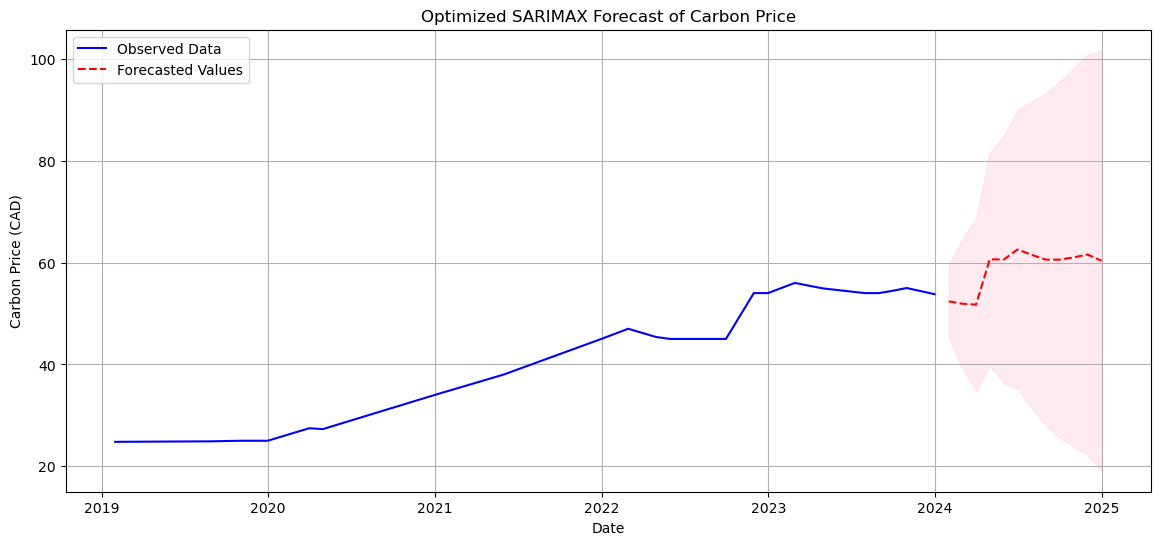

In [11]:
# Forecasting the next 12 months
forecast_steps = 12
forecast = optimized_results.get_forecast(steps=forecast_steps, exog=exog.iloc[-forecast_steps:])

# Extracting the predicted mean and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Get the future dates starting from the last observed date
last_date = target.index[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]

# Set the future dates as the index for the forecast values
forecast_values.index = future_dates
confidence_intervals.index = future_dates

# Plot the observed data and the forecasted values
plt.figure(figsize=(14, 6))
plt.plot(target.index, target, color='blue', label='Observed Data')
plt.plot(forecast_values.index, forecast_values, color='red', linestyle='--', label='Forecasted Values')

# Plot the confidence intervals
plt.fill_between(confidence_intervals.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Carbon Price (CAD)')
plt.title('Optimized SARIMAX Forecast of Carbon Price')
plt.legend()
plt.grid()
plt.show()


In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define and fit the SARIMAX model
model = SARIMAX(combined_data['TIER Carbon Credit (CAD)'], 
                order=(1, 1, 0),  # Adjust these based on your ACF/PACF plots
                seasonal_order=(0, 1, 0, 12),  # Assuming yearly seasonality
                exog=combined_data[['Quantity', 'Supply_Demand_Ratio']]) 

results = model.fit()

# Print model summary
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:           TIER Carbon Credit (CAD)   No. Observations:                   23
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -26.937
Date:                            Thu, 29 Jan 2026   AIC                             61.874
Time:                                    15:22:36   BIC                             63.084
Sample:                                         0   HQIC                            60.546
                                             - 23                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Quantity             7.141e-09   4.26e-09      1.677      0.094    -1.2e-09    1.55e-08
Supply_D

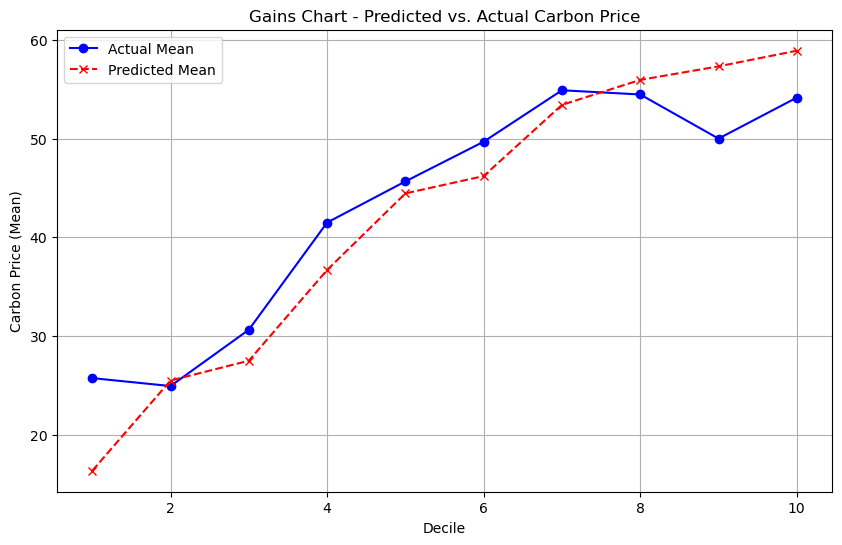

In [47]:
# Generate predictions for the entire dataset
predictions = simplified_results.get_prediction().predicted_mean

# Create a DataFrame to compare actual vs. predicted
combined_data['Predictions'] = predictions

# Sort data into deciles based on the predicted values
combined_data['Decile'] = pd.qcut(combined_data['Predictions'], q=10, labels=False) + 1
gains_table = combined_data.groupby('Decile').agg({
    'TIER Carbon Credit (CAD)': ['mean', 'count'],
    'Predictions': 'mean'
}).reset_index()
gains_table.columns = ['Decile', 'Actual Mean', 'Count', 'Predicted Mean']

# Plot the gains chart
plt.figure(figsize=(10, 6))
plt.plot(gains_table['Decile'], gains_table['Actual Mean'], color='blue', marker='o', label='Actual Mean')
plt.plot(gains_table['Decile'], gains_table['Predicted Mean'], color='red', linestyle='--', marker='x', label='Predicted Mean')
plt.xlabel('Decile')
plt.ylabel('Carbon Price (Mean)')
plt.title('Gains Chart - Predicted vs. Actual Carbon Price')
plt.legend()
plt.grid()
plt.show()


RMSE: 6.73


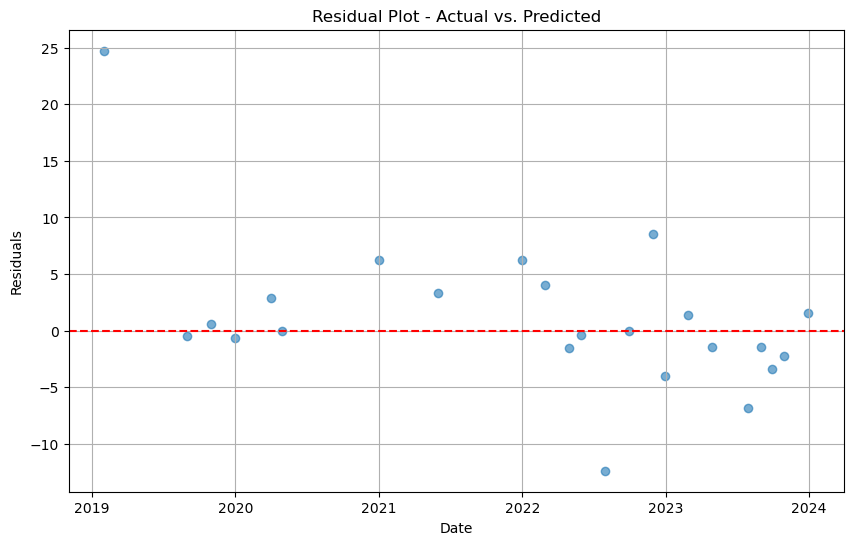

In [49]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(combined_data['TIER Carbon Credit (CAD)'].dropna(), predictions.dropna()))
print(f'RMSE: {rmse:.2f}')

# Residual Plot
plt.figure(figsize=(10, 6))
residuals = combined_data['TIER Carbon Credit (CAD)'] - combined_data['Predictions']
plt.scatter(combined_data.index, residuals, alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residual Plot - Actual vs. Predicted')
plt.grid()
plt.show()


## Key Takeaways

- Carbon credit prices exhibit a strong upward trend with weak seasonal effects.
- A simple ARIMA model captures overall price movement without unnecessary complexity.
- Forecast accuracy is reasonable given the limited historical window and policy-driven shocks.

Limitations include:
- Small monthly sample size
- Structural breaks due to regulatory changes
- Absence of real-time demand-side transaction data
